<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from numpy.random import seed
seed(1337)

import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


Text(0.5, 1.0, 'Number of training images per category:')

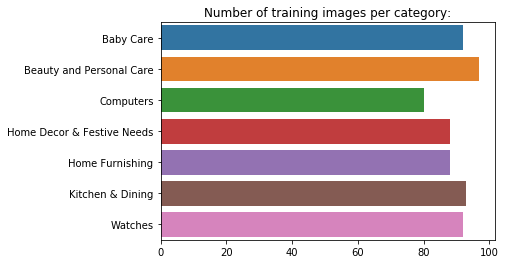

In [2]:
train_data_dir = "data/train"
val_data_dir = "data/validation"
test_data_dir = "data/test"
category_names = sorted(os.listdir('data/train'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = 'data/train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))

sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

Let's plot some example of the images

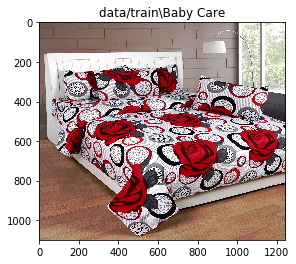

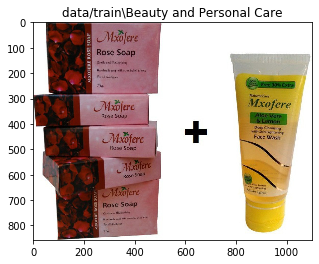

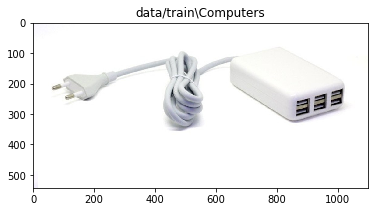

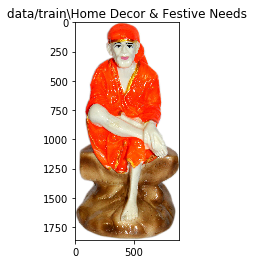

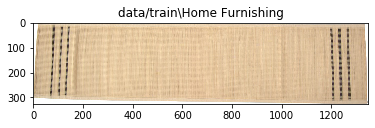

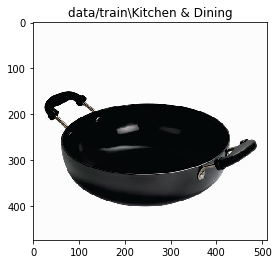

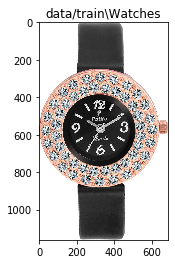

In [3]:
for subdir, dirs, files in os.walk('data/train'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break

We will use vgg16 for the transfer learning, let's import the model

In [4]:
img_height, img_width = 224,224
conv_base = vgg16.VGG16(weights='imagenet', include_top=False,
                        pooling='max',
                        input_shape = (img_width, img_height, 3))

Let's print all the layers of the model

In [5]:
for layer in conv_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000272FA15DF48> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000272FDD96908> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000272FE4D0548> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000272BD1F2A88> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000272BD1F2608> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000272BD200548> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000272BD209748> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000272BD203D88> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000272BD214248> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000272BD21B0C8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000272BD224608> True
<tensorflow.python.keras.layer

And the number of parameters to train if we train all the layers or just few

In [6]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 7)                 3591      
Total params: 14,718,279
Trainable params: 14,718,279
Non-trainable params: 0
_________________________________________________________________


Let's init all the variables we need to train the model

In [7]:
#Number of images to load at each iteration
batch_size = 32

# only rescaling
train_datagen =  ImageDataGenerator(
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)

# these are generators for train/test data that will read pictures 
# found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
val_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

Total number of images for "training":
Found 630 images belonging to 7 classes.
Total number of images for "validation":
Found 210 images belonging to 7 classes.
Total number of images for "testing":
Found 210 images belonging to 7 classes.


In [8]:
learning_rate = 5e-5
epochs = 10
steps_per_epoch = 2
validation_steps = 2

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint  = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate,
                                        clipnorm = 1.),
              metrics=['acc'])

We're now ready to train the model

In [9]:
tf.keras.backend.clear_session()

In [10]:
history = model.fit(train_generator, 
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    shuffle=True, 
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[checkpoint]
                    )

Epoch 1/10
2/2 [==============================] - 3s 2s/step - loss: 2.8473 - acc: 0.1562 - val_loss: 2.2880 - val_acc: 0.0156
Epoch 2/10
2/2 [==============================] - 4s 2s/step - loss: 1.9498 - acc: 0.2969 - val_loss: 2.1198 - val_acc: 0.1094
Epoch 3/10
2/2 [==============================] - 4s 2s/step - loss: 1.7805 - acc: 0.2812 - val_loss: 1.6544 - val_acc: 0.3600
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 1.6509 - acc: 0.3750 - val_loss: 2.2225 - val_acc: 0.0312
Epoch 5/10
2/2 [==============================] - 3s 1s/step - loss: 1.4543 - acc: 0.5000 - val_loss: 0.6778 - val_acc: 0.8600
Epoch 6/10
2/2 [==============================] - 3s 1s/step - loss: 1.4244 - acc: 0.5156 - val_loss: 1.6714 - val_acc: 0.4375
Epoch 7/10
2/2 [==============================] - 3s 2s/step - loss: 1.5392 - acc: 0.4688 - val_loss: 1.4384 - val_acc: 0.3438
Epoch 8/10
2/2 [==============================] - 3s 1s/step - loss: 1.2983 - acc: 0.4844 - val_loss: 1.1700 - 

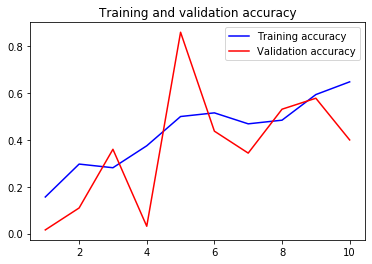

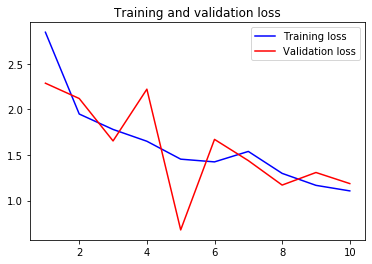

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('Accuracy.jpg')

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('Loss.jpg')

In [12]:
tf.keras.backend.clear_session()

In [13]:
learning_rate = 5e-5
epochs = 10
steps_per_epoch = 2
validation_steps = 2

checkpoint = ModelCheckpoint("sign_classifier.h5", monitor='val_acc', verbose=1,
                             save_best_only=False, save_weights_only=False,
                             mode='auto', save_freq=1)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate,
                                        clipnorm = 1.),
              metrics=['acc'])

In [14]:
history = model.fit(train_generator, 
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    shuffle=True, 
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[checkpoint]
                    )

Epoch 1/10

Epoch 00001: saving model to sign_classifier.h5
1/2 [==============>...............] - ETA: 0s - loss: 0.7502 - acc: 0.8438
Epoch 00001: saving model to sign_classifier.h5
2/2 [==============================] - 3s 1s/step - loss: 0.8986 - acc: 0.7188 - val_loss: 1.8116 - val_acc: 0.2812
Epoch 2/10

Epoch 00002: saving model to sign_classifier.h5
1/2 [==============>...............] - ETA: 0s - loss: 0.7580 - acc: 0.7500
Epoch 00002: saving model to sign_classifier.h5
2/2 [==============================] - 2s 1s/step - loss: 0.8340 - acc: 0.7031 - val_loss: 0.7163 - val_acc: 0.8000
Epoch 3/10

Epoch 00003: saving model to sign_classifier.h5
1/2 [==============>...............] - ETA: 0s - loss: 0.8516 - acc: 0.6875
Epoch 00003: saving model to sign_classifier.h5
2/2 [==============================] - 2s 1s/step - loss: 0.7572 - acc: 0.7344 - val_loss: 0.9475 - val_acc: 0.7031
Epoch 4/10

Epoch 00004: saving model to sign_classifier.h5
1/2 [==============>...............] - E

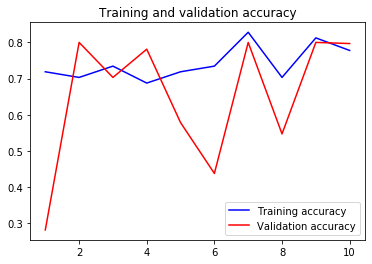

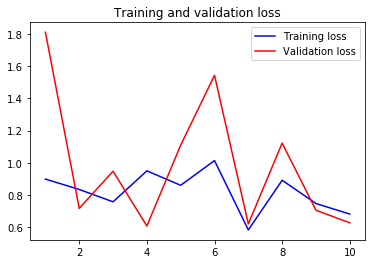

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('Accuracy.jpg')

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('Loss.jpg')